#### **Установка всех необходимых библиотек**

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install -U torchmetrics
!pip install ipdb
clear_output()

#### **Скачивание данных**

In [ ]:
!wget -O positive.csv https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0
!wget -O negative.csv https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0
clear_output()

#### **Импорт библиотек**

In [ ]:
import random
import re
from collections import Counter
from warnings import filterwarnings

import ipdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import (
    DataLoader,
    Dataset,
    RandomSampler,
    SequentialSampler,
)
from torchmetrics.functional import precision, recall
from torchmetrics.functional.classification.f_beta import f1_score
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 6)

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
filterwarnings("ignore")

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#### **Препроцессинг**

In [ ]:
def preprocess(text: str) -> str:
    """
    Функция для препроцессинга текстов.

    Parameters:
        text: str

    Returns:
        str
    """
    text = text.lower().replace("ё", "е")
    text = re.sub("((www\.[^\s]+)|(https?://[^\s]+))", "URL", text)
    text = re.sub("@[^\s]+", "USER", text)
    text = re.sub("[^a-zA-Zа-яА-Я1-9]+", " ", text)
    text = re.sub(" +", " ", text)
    return text.strip()

In [ ]:
pos_tweets = pd.read_csv(
    "positive.csv", encoding="utf-8", sep=";", header=None,
    names=[0, 1, 2, "text", "tone", 5, 6, 7, 8, 9, 10, 11]
    )

neg_tweets = pd.read_csv(
    "negative.csv", encoding="utf-8", sep=";", header=None,
    names=[0, 1, 2, "text", "tone", 5, 6, 7, 8, 9, 10, 11]
    )
neg_tweets["tone"] = 0

In [ ]:
corpus = pd.concat([pos_tweets, neg_tweets])[["text", "tone"]].sample(frac=1).reset_index(drop=True)

In [ ]:
df = corpus[:100000]
df["clean_text"] = df["text"].apply(preprocess)

In [ ]:
df.head()

,text,tone,clean_text
0,мыс на меня обиделась:(\nя ей даже ничего не с...,0,мыс на меня обиделась я ей даже ничего не сделала
1,"аааааааааааааааааааа,не хочу на работу :(",0,аааааааааааааааааааа не хочу на работу
2,"У меня какой-то особенный вид ушей! :D, некото...",1,у меня какой то особенный вид ушей d некоторые...
3,@simonovkon он неплохой человек в жизни. Я ра...,0,USER он неплохой человек в жизни я работала в ...
4,"RT @Darina_Lo: Домааааа\nЕхали на такси, пели ...",1,rt USER домааааа ехали на такси пели песни отд...


Удаляем всё массивное и ненужное.

In [ ]:
!rm *.csv

In [ ]:
del pos_tweets
del neg_tweets
del corpus

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.1)

In [ ]:
vocab = Counter(" ".join(df["clean_text"]).split())
print(f"Всего уникальных токенов: {len(vocab)}")

Всего уникальных токенов: 111423


In [ ]:
filtered_vocab = {word for word in vocab if vocab[word] > 2}
print(f"Токенов, встретившихся больше 2 раз: {len(filtered_vocab)}")

Токенов, встретившихся больше 2 раз: 29118


In [ ]:
symbols = Counter("".join(df["text"]))
print(f"Всего уникальных символов: {len(symbols)}")

Всего уникальных символов: 369


In [ ]:
filtered_symbols = {symbol for symbol in symbols if symbols[symbol] > 10}
print(f"Символов, встретившихся больше 10 раз: {len(filtered_symbols)}")

Символов, встретившихся больше 10 раз: 197


In [ ]:
word2id = {"PAD": 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i: word for word, i in word2id.items()}

In [ ]:
symbol2id = {"PAD": 0}

for symbol in filtered_symbols:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i: symbol for symbol, i in symbol2id.items()}

#### **Функции для обучения и валидации**

In [ ]:
def train(model, iterator, optatasetimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, ys) in tqdm(enumerate(iterator)):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)
        loss.backward() 
        optimizer.step()
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator) / 5):
            print(f"Train loss: {epoch_loss / i}")      
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys) 
            epoch_loss += loss.item()
            batch_metric = f1_score(
                preds.round().long(), ys.long(), ignore_index=0
                )
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator) / 5):
              print(f"Val loss: {epoch_loss / i}, Val f1: {epoch_metric / i}")
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [ ]:
def predict(model, iterator):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, (words, ys) in enumerate(iterator): 
            for word in model(words):
                preds.append(word.cpu().detach().numpy().round())
    return preds

In [ ]:
def train_symb(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, symbols, ys) in tqdm(enumerate(iterator)):
        optimizer.zero_grad()
        preds = model(texts, symbols)
        loss = criterion(preds, ys)
        loss.backward() 
        optimizer.step()
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator) / 5):
            print(f"Train loss: {epoch_loss / i}")      
    return  epoch_loss / len(iterator)

In [ ]:
def evaluate_symb(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, symbols, ys) in enumerate(iterator):   
            preds = model(texts, symbols)
            loss = criterion(preds, ys) 
            epoch_loss += loss.item()
            batch_metric = f1_score(
                preds.round().long(), ys.long(), ignore_index=0
                )
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator) / 5):
              print(f"Val loss: {epoch_loss / i}, Val f1: {epoch_metric / i}")
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [ ]:
def predict_symb(model, iterator):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, (words, symbols, ys) in enumerate(iterator): 
            for word in model(words, symbols):
                preds.append(word.cpu().detach().numpy().round())
    return preds

# **CNN на уровне слов**

#### **Dataset & DataLoader**

In [ ]:
class TweetsDataset(Dataset):
    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset["text"].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset["tone"].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, idx): 
        tokens = self.preprocess(self.dataset[idx])
        ids = torch.LongTensor(
            [self.word2id[token] for token in tokens if token in self.word2id]
            )
        y = [self.target[idx]]
        return ids, y

    def preprocess(self, text):
        text = text.lower().replace("ё", "е")
        text = re.sub("((www\.[^\s]+)|(https?://[^\s]+))", "URL", text)
        text = re.sub("@[^\s]+", "USER", text)
        text = re.sub("[^a-zA-Zа-яА-Я1-9]+", " ", text)
        text = re.sub(" +", " ", text)
        return text.strip()

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [ ]:
train_dataset = TweetsDataset(train_df, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(
    train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler,
    batch_size=128
    )

val_dataset = TweetsDataset(val_df, word2id, DEVICE)
val_sampler = RandomSampler(val_dataset)
val_iterator = DataLoader(
    val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler,
    batch_size=128
    )

#### **FastText**

In [ ]:
fasttext = FastText(df["clean_text"].tolist(), size=100, window=5, min_count=1)

In [ ]:
weights = np.zeros((len(word2id), 100))
for word, i in word2id.items():
    if word in fasttext.wv:
        weights[i] = fasttext.wv[word]
    elif word != "PAD":
        weights[i] = np.random.normal(0, 0.1, 100)

#### **Архитектура модели**

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(
            in_channels=embedding_size, out_channels=100,
            kernel_size=2, padding="same"
            )
        self.trigrams = nn.Conv1d(
            in_channels=embedding_size, out_channels=80,
            kernel_size=3, padding="same"
            )
        self.bigrams2 = nn.Conv1d(
            in_channels=180, out_channels=180, kernel_size=2, padding="same"
            )
        self.pooling = nn.MaxPool1d(kernel_size=3, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1, 2)
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        bigrams = self.pooling(self.relu(self.bigrams2(concat)))
        pooling = bigrams.max(2)[0]
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [ ]:
model = CNN(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

#### **Обучение и валидация**

In [ ]:
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

for i in range(1, 11):
    print(f"Starting Epoch {i}")
    print("Training...")
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    train_losses.append(epoch_loss)
    print("Evaluating on train...")
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    train_f1s.append(f1_on_train)
    print("Evaluating on test...")
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)

clear_output()

In [ ]:
print(f"val loss: {val_losses[-1]}, val f1-score: {val_f1s[-1]}")

val loss: 0.5257393823394293, val f1-score: 0.7379230856895447


#### **Графики метрик**

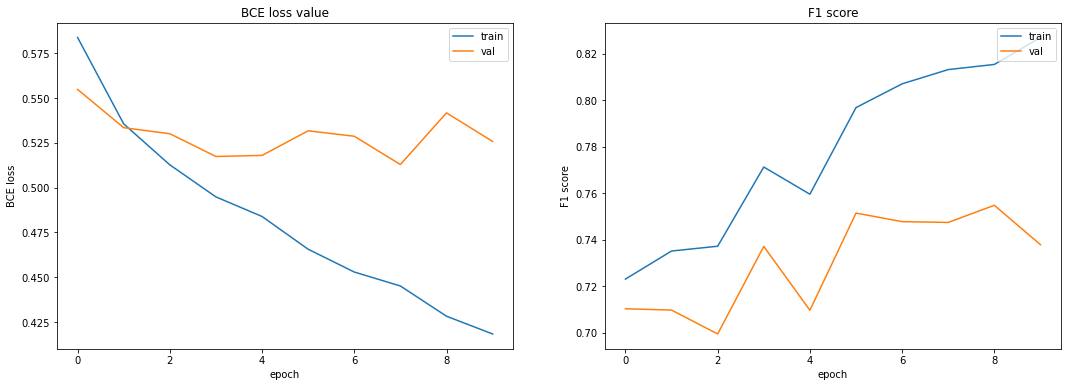

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(train_losses, label="train")
ax1.plot(val_losses, label="val")
ax1.set_title("BCE loss value")
ax1.set(xlabel="epoch", ylabel="BCE loss")
ax1.legend(loc="upper right")

ax2.plot(train_f1s, label="train")
ax2.plot(val_f1s, label="val")
ax2.set_title("F1 score")
ax2.set(xlabel="epoch", ylabel="F1 score")
ax2.legend(loc="upper right")

#### **Улучшение архитектуры**
Попытаемся ещё улучшить качество предсказаний модели, немного поменяв архитектуру.

In [ ]:
class CNNTweaked(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(
            in_channels=embedding_size, out_channels=100,
            kernel_size=2, padding="same"
            )
        self.trigrams = nn.Conv1d(
            in_channels=embedding_size, out_channels=80,
            kernel_size=3, padding="same"
            )
        self.bigrams2 = nn.Conv1d(
            in_channels=180, out_channels=180, kernel_size=2, padding="same"
            )
        self.pooling = nn.MaxPool1d(kernel_size=3, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5) # добавим dropout
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1, 2)
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        bigrams = self.dropout(self.pooling(self.relu(self.bigrams2(concat))))
        pooling = bigrams.max(2)[0]
        logits = self.hidden(pooling)
        logits = self.out(logits)      
        return logits

In [ ]:
model_new = CNNTweaked(len(word2id), 100)
# изменим параметры оптимайзера — повысим learning rate и добавим weight decay
optimizer = optim.Adam(model_new.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCELoss()

model_new = model_new.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

for i in range(1, 11):
    print(f"Starting Epoch {i}")
    print("Training...")
    epoch_loss = train(model_new, train_iterator, optimizer, criterion)
    train_losses.append(epoch_loss)
    print("Evaluating on train...")
    f1_on_train,_ = evaluate(model_new, train_iterator, criterion)
    train_f1s.append(f1_on_train)
    print("Evaluating on test...")
    f1_on_test, epoch_loss_on_test = evaluate(
        model_new, val_iterator, criterion
        )
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)

clear_output()

In [ ]:
print(f"val loss: {val_losses[-1]}, val f1-score: {val_f1s[-1]}")

val loss: 0.5294078018846391, val f1-score: 0.7514127492904663


Результаты предыдущей модели:

```
val loss: 0.5257393823394293, val f1-score: 0.7379230856895447
```
Результаты новой модели:
```
val loss: 0.5294078018846391, val f1-score: 0.7514127492904663
```
Добавление дропаута и изменение параметров оптимайзера незначительно, но улучшило качество модели!

# **Комбинация эмбеддингов и символьных признаков**

#### **Dataset & DataLoader**

In [ ]:
class WordSymbDataset(Dataset):
    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset["clean_text"].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset["tone"].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, idx): 
        tokens = self.dataset[idx].split()
        word_ids = torch.LongTensor(
            [self.word2id[token] for token in tokens if token in self.word2id]
            )
        symbols = list(self.dataset[idx])
        symbol_ids = torch.LongTensor(
            [self.symbol2id[symbol] for symbol in symbols
             if symbol in self.symbol2id]
            )
        y = [self.target[idx]]
        return word_ids, symbol_ids, y

    def collate_fn(self, batch):
      word_ids, symbol_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbols = pad_sequence(
          symbol_ids, batch_first=True
          ).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbols, y

In [ ]:
train_dataset = WordSymbDataset(train_df, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(
    train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler,
    batch_size=128
    )

val_dataset = WordSymbDataset(val_df, word2id, symbol2id, DEVICE)
val_sampler = RandomSampler(val_dataset)
val_iterator = DataLoader(
    val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler,
    batch_size=128
    )

#### **Архитектура модели**

In [ ]:
class SymbCNN(nn.Module):
    def __init__(
        self, word_vocab_size, word_embedding_size,
        symb_vocab_size, symb_embedding_size
        ):
        super().__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_size)
        self.word_embedding.from_pretrained(
            torch.tensor(weights), freeze=True
            )
        self.word_hidden = nn.Linear(100, 100)
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_size)
        self.bigrams = nn.Conv1d(
            in_channels=symb_embedding_size, out_channels=100,
            kernel_size=2, padding="same"
            )
        self.trigrams = nn.Conv1d(
            in_channels=symb_embedding_size, out_channels=80,
            kernel_size=3, padding="same"
            )
        self.pooling = nn.MaxPool1d(kernel_size=3, stride=2)
        self.symb_hidden = nn.Linear(in_features=180, out_features=100)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=200, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, words, symbols):
        symb_embedded = self.symb_embedding(symbols)
        symb_embedded = symb_embedded.transpose(1, 2)
        feature_map_bigrams = self.pooling(
            self.relu(self.bigrams(symb_embedded))
            )
        feature_map_trigrams = self.pooling(
            self.relu(self.trigrams(symb_embedded))
            )
        pool1 = feature_map_bigrams.max(2)[0]
        pool2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pool1, pool2), 1)
        symb_vec = self.symb_hidden(concat)
        words_embedded = torch.mean(self.word_embedding(words), dim=1)
        words_vec = self.relu(self.word_hidden(words_embedded))
        concat = torch.cat((symb_vec, words_vec), 1)
        logits = self.out(self.hidden(concat))
        return logits

In [ ]:
model = SymbCNN(len(word2id), 100, len(symbol2id), 10)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

#### **Обучение и валидация**

In [ ]:
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

for i in range(1, 11):
    print(f"Starting Epoch {i}")
    print("Training...")
    epoch_loss = train_symb(model, train_iterator, optimizer, criterion)
    train_losses.append(epoch_loss)
    print("Evaluating on train...")
    f1_on_train,_ = evaluate_symb(model, train_iterator, criterion)
    train_f1s.append(f1_on_train)
    print("Evaluating on test...")
    f1_on_test, epoch_loss_on_test = evaluate_symb(
        model, val_iterator, criterion
        )
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)

clear_output()

In [ ]:
print(f"val loss: {val_losses[-1]}, val f1-score: {val_f1s[-1]}")

val loss: 0.5227422088007384, val f1-score: 0.7565941214561462


#### **Графики метрик**

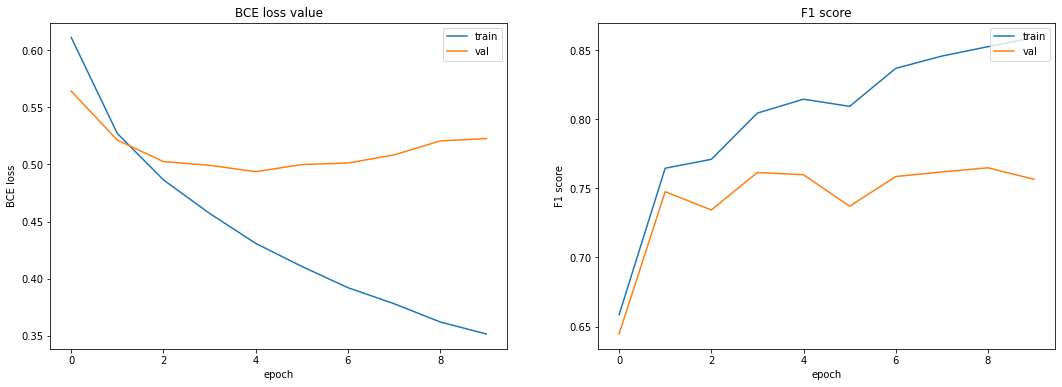

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(train_losses, label="train")
ax1.plot(val_losses, label="val")
ax1.set_title("BCE loss value")
ax1.set(xlabel="epoch", ylabel="BCE loss")
ax1.legend(loc="upper right")

ax2.plot(train_f1s, label="train")
ax2.plot(val_f1s, label="val")
ax2.set_title("F1 score")
ax2.set(xlabel="epoch", ylabel="F1 score")
ax2.legend(loc="upper right")

#### **Улучшение архитектуры**
Попробуем также добавить dropout, увеличить learning rate и добавить weight decay.

In [ ]:
class SymbCNNTweaked(nn.Module):
    def __init__(
        self, word_vocab_size, word_embedding_size,
        symb_vocab_size, symb_embedding_size
        ):
        super().__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_size)
        self.word_embedding.from_pretrained(
            torch.tensor(weights), freeze=True
            )
        self.word_hidden = nn.Linear(100, 100)
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_size)
        self.bigrams = nn.Conv1d(
            in_channels=symb_embedding_size, out_channels=100,
            kernel_size=2, padding="same"
            )
        self.trigrams = nn.Conv1d(
            in_channels=symb_embedding_size, out_channels=80,
            kernel_size=3, padding="same"
            )
        self.pooling = nn.MaxPool1d(kernel_size=3, stride=2)
        self.symb_hidden = nn.Linear(in_features=180, out_features=100)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, words, symbols):
        symb_embedded = self.symb_embedding(symbols)
        symb_embedded = symb_embedded.transpose(1, 2)
        feature_map_bigrams = self.pooling(
            self.relu(self.bigrams(symb_embedded))
            )
        feature_map_trigrams = self.pooling(
            self.relu(self.trigrams(symb_embedded))
            )
        pool1 = feature_map_bigrams.max(2)[0]
        pool2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pool1, pool2), 1)
        symb_vec = self.symb_hidden(concat)
        words_embedded = torch.mean(self.word_embedding(words), dim=1)
        words_vec = self.dropout(
            self.relu(self.dropout(self.word_hidden(words_embedded)))
            )
        concat = torch.cat((symb_vec, words_vec), 1)
        logits = self.out(self.hidden(concat))      
        return logits

In [53]:
model_new = SymbCNNTweaked(len(word2id), 100, len(symbol2id), 10)
# изменим параметры оптимайзера — повысим learning rate и добавим weight decay
optimizer = optim.Adam(model_new.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCELoss()

model_new = model_new.to(DEVICE)
criterion = criterion.to(DEVICE)

In [54]:
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

for i in range(1, 11):
    print(f"Starting Epoch {i}")
    print("Training...")
    epoch_loss = train_symb(model_new, train_iterator, optimizer, criterion)
    train_losses.append(epoch_loss)
    print("Evaluating on train...")
    f1_on_train,_ = evaluate_symb(model_new, train_iterator, criterion)
    train_f1s.append(f1_on_train)
    print("Evaluating on test...")
    f1_on_test, epoch_loss_on_test = evaluate_symb(
        model, val_iterator, criterion
        )
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)

clear_output()

In [55]:
print(f"val loss: {val_losses[-1]}, val f1-score: {val_f1s[-1]}")

val loss: 0.5169867443133004, val f1-score: 0.7624869346618652


Стало немного лучше.

  # **Анализ ошибок**